In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range
import random

import pickle

import psutil
import platform
import math
import time
from datetime import datetime, timedelta

import scipy.io

# Import the required modules
import cv2
import os

import glob
import random


import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

ImportError: No module named 'cv2'

In [2]:
# https://anaconda.org/menpo/opencv3
#    conda install -c menpo opencv3=3.1.0
import cv2  

# Advanced Scene Detection Parameters
INTENSITY_THRESHOLD = 16    # Pixel intensity threshold (0-255), default 16
MINIMUM_PERCENT     = 95    # Min. amount of pixels to be below threshold.
BLOCK_SIZE          = 32    # Num. of rows to sum per iteration.

---
#### Shot Transition Detection using *PySceneDetect*:
- http://www.bcastell.com/projects/pyscenedetect/#psd_doc_sysreq
- https://github.com/Breakthrough/python-scene-detection-tutorial/blob/master/README.md
- https://pyscenedetect.readthedocs.io/en/latest/

#### References:
- https://en.wikipedia.org/wiki/Shot_transition_detection
- https://pdfs.semanticscholar.org/b2d7/19643c2ebf45c26f0e1e2234e62289391c09.pdf
---

In [3]:
from pytube import YouTube
#   pip install pytube

# 007 GoldenEye (1995) - Boris Sends a Spike.mp4
#video_url = "https://www.youtube.com/watch?v=OMgIPnCnlbQ" 

# Jason Bourne - Featurette - Bourne In 90 Seconds (HD).mp4
#video_url = "https://www.youtube.com/watch?v=N3dJLRfBtu4"

# Pink Floyd Greatest Hits (HQHD)  The Very Best Of Pink Floyd.mp4
#video_url = "https://www.youtube.com/watch?v=V-jhtORMaZM"

# Divergent in 30 seconds.mp4
video_url = "https://www.youtube.com/watch?v=6rEsMHH1SII"
    
yt = YouTube(video_url)
# view the auto generated filename:
myVideoFile = yt.filename+'.mp4'

# In case of multiple resolutions, select video 
# with owest resolution for faster download times
video = yt.filter('mp4')[0]  ##yt.get('mp4', '360p')

# download video file in current folder
download_folder = './data'
if not os.path.isfile(download_folder + '/' + myVideoFile):
    print("Downloading video file [" + myVideoFile + "] ......")
    %time video.download(download_folder)
else: 
    print("Skip downloading video file [" + myVideoFile + "] - already exists!")

Skip downloading video file [Divergent in 30 seconds.mp4] - already exists!


In [4]:
import urllib.request

#-------------------------------------------------------------
# this section is for downloading mp4 http endpoints
# uncomment if not using YouTube download from previous cell
#-------------------------------------------------------------

#myVideoFile = "testvideo.mp4"
#video_url = "https://github.com/Breakthrough/python-scene-detection-tutorial/blob/master/examples/" + myVideoFile

#urllib.request.urlretrieve(video_url, download_folder + '/' + myVideoFile)

In [5]:
# original test video from PySceneDetect example
# myVideoFile = 'testvideo.mp4'
myVideoFile = download_folder = './data' + '/' + myVideoFile

In [37]:
import io
import base64
from IPython.display import HTML

video = io.open(myVideoFile, 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<div style="text-align: center">
                  <iframe width="650" height="400" src="data:video/mp4;base64,{0}" type="video/mp4">
                  </iframe>
            </div>'''.format(encoded.decode('ascii')))

In [7]:
# code fix using below examples:
# http://stackoverflow.com/questions/30013009/opencv-3-0-0-dev-python-bindings-not-working-properly
# http://stackoverflow.com/questions/26559179/cap-prop-frame-count-constant-is-missing-in-opencv-cv2-python-module

def process_video(video_input, threshold_input):    
    cap = cv2.VideoCapture()
    cap.open(video_input)
    
    if not cap.isOpened():
        print("Fatal error - could not open video %s." % threshold_input)
        return
    else:
        print("Parsing video %s..." % threshold_input)
        
    # Do stuff with cap here.
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("Video Resolution: %d x %d" % (width, height))

    # Allow the threshold to be passed as an optional, second argument to the script.
    threshold = 16
    if threshold_input:
       threshold = int(threshold_input)
    print("Detecting scenes with threshold = %d" % threshold)
    print("Min. pixels under threshold = %d %%" % MINIMUM_PERCENT)
    print("Block/row size = %d" % BLOCK_SIZE)
    
    print("")
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    print("# of frames to process: %d" % (frame_count) )


    print("")

    min_percent = MINIMUM_PERCENT / 100.0
    num_rows    = BLOCK_SIZE
    last_amt    = 0     # Number of pixel values above threshold in last frame.
    start_time  = cv2.getTickCount()  # Used for statistics after loop.

    (rv, im) = cap.read()
    print('Image shape: ', im.shape)

    shots = []
    while True:
        # Get next frame from video.
        (rv, im) = cap.read()
        if not rv:   # im is a valid image if and only if rv is true
            break

        # Compute number of pixel values and minimum amount to trigger fade.
        num_pixel_vals = float(im.shape[0] * im.shape[1] * im.shape[2])
        min_pixels     = int(num_pixel_vals * (1.0 - min_percent))

        # Loop through frame block-by-block, updating current sum.
        frame_amt = 0
        curr_row  = 0
        while curr_row < im.shape[0]:
            # Add # of pixel values in current block above the threshold.
            frame_amt += np.sum(
                im[curr_row : curr_row + num_rows,:,:] > threshold )
            if frame_amt > min_pixels:  # We can avoid checking the rest of the
                break                   # frame since we crossed the boundary.
            curr_row += num_rows


        # Detect fade in from black.
        if frame_amt >= min_pixels and last_amt < min_pixels:
            pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
            pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            fade_in_out = 'IN'
            label = "Fade %s at %dms [frame %d]" % (fade_in_out, pos_msec, pos_frame)
            print(label)
            shots.append({"frame": pos_frame, "msec": pos_msec, "fade": fade_in_out, "label": label})
        # Detect fade out to black.
        elif frame_amt < min_pixels and last_amt >= min_pixels:
            pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
            pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            fade_in_out = 'OUT'
            label = "Fade %s at %dms [frame %d]" % (fade_in_out, pos_msec, pos_frame)
            print(label)
            shots.append({"frame": pos_frame, "msec": pos_msec, "fade": fade_in_out, "label": label})

        last_amt = frame_amt      # Store current mean to compare in next iteration.

    # Get # of frames in video based on the position of the last frame we read
    # cap.get(cv2.CAP_PROP_POS_FRAMES) <-- this did not work
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) 
    # Compute runtime and average framerate
    total_runtime = float(cv2.getTickCount() - start_time) / cv2.getTickFrequency()
    avg_framerate = float(frame_count) / total_runtime

    print("")
    print("Read %d frames from video in %4.2f seconds (avg. %4.1f FPS)." % (
        frame_count, total_runtime, avg_framerate) )
    print("")

    cap.release()
    
    return shots

In [8]:
%time shots = process_video(myVideoFile,50)

Parsing video 50...
Video Resolution: 360 x 360
Detecting scenes with threshold = 50
Min. pixels under threshold = 95 %
Block/row size = 32

# of frames to process: 883

Image shape:  (360, 360, 3)
Fade IN at 66ms [frame 2]

Read 883 frames from video in 4.42 seconds (avg. 199.8 FPS).

CPU times: user 1.4 s, sys: 541 ms, total: 1.94 s
Wall time: 4.77 s


In [9]:
cap = cv2.VideoCapture()
cap.open(myVideoFile)

True

In [10]:
# grab an individual frame
def grab_one_frame(cap, frame_num, pos_vs_msec_flag):
    f = frame_num
    if pos_vs_msec_flag == 0:
        # read frame by time (milliseconds) offset
        cap.set(cv2.CAP_PROP_POS_MSEC, f) 
    else:
        # read frame by frame#
        cap.set(cv2.CAP_PROP_POS_FRAMES, f) 

    (rv, img) = cap.read()
    pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
    return img, int(pos_frame), pos_msec

# of shots:  1


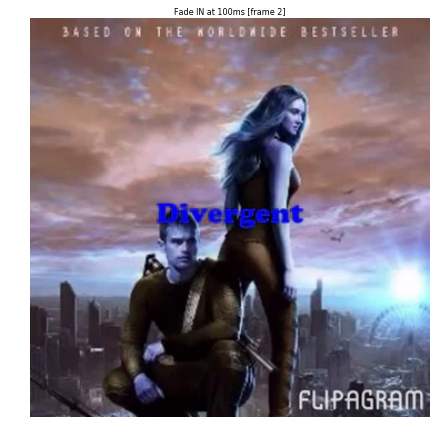

In [11]:
import matplotlib.gridspec as gridspec

print('# of shots: ', len(shots))

num_per_row = 2
rows = int(len(shots)/num_per_row)

if (rows*num_per_row) < len(shots):
   rows = rows + 1
rows = rows*2  # for better placement in the grid, though don't know why this works and not 'hspace=0'

plt.close('all')
plt.ion()
fig = plt.figure(figsize=(15,21))
gs1 = gridspec.GridSpec(rows, num_per_row)
gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 

for fig_pos, shot in enumerate(shots):
    # direct vizualization of the images for the fade in/out cuts
    fade_in_out = shot['fade']
    pos_msec = shot['msec']
    pos_frame = shot['frame']
    img, pos_frame, pos_msec = grab_one_frame(cap, pos_frame, 1)
    label = "Fade %s at %dms [frame %d]" % (fade_in_out, pos_msec, pos_frame)
    imgplot = fig.add_subplot(gs1[fig_pos]) # fig.add_subplot(1,6,fig_pos+1) 
    imgplot.imshow(img, cmap=plt.get_cmap('gray')) # 'CMRmap' provides decent color pictures
    imgplot.set_title(label, fontsize=8)
    imgplot.axis('off')

plt.show()

### HAAR Classifier for Face Detection:

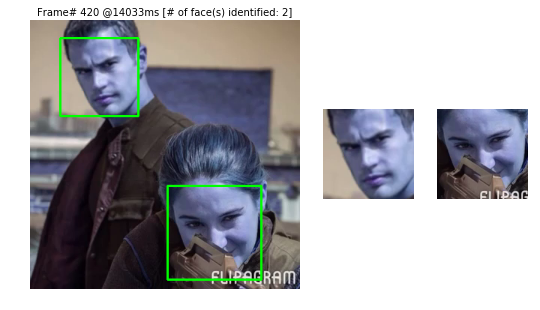

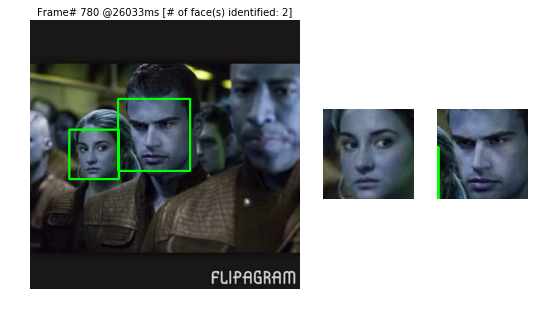

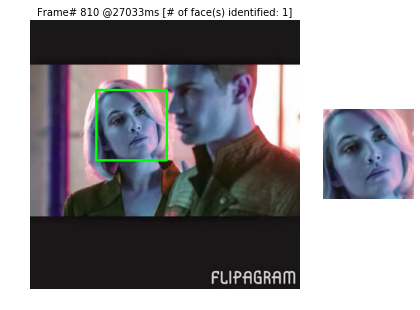

In [12]:
# Create the haar cascade
cascPath = '/Users/nlabh/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)
 
kp = [ [0, 7050], [1, 160], [1, 300], [1, 350] ]
ge = [ [1, 1100], [0, 27000], [0, 16000], [1, 1150], [1, 1200], [1, 1750] ]
jb = [ [1, 100], [0, 18000], [0, 19800], [0, 21300], [1, 580], [1, 640], [0, 46296] ]
dv = [[0, 14000], [0, 26000], [0, 27000]]

# Specifying image position as [0|1, <pos|msec]; 
#    where:
#       - 0 indicates msec in 2nd position
#       - 1 indicates frame# in 2nd position
# Read the image at specified frame position at offset - msec/frame#
for msec_pos_frame in dv:
    image, pos_frame, pos_msec = grab_one_frame(cap, msec_pos_frame[1], msec_pos_frame[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    
    num_faces = len(faces)

    identified_faces = []
    # Draw a rectangle around the faces and extract them out
    for i, (x, y, w, h) in enumerate(faces):
        #identified_faces.append(np.array(image[int(y*.5):int(y+h+(y*.5)),int(x*.8):int(x+w+(x*.2)),:]))
        identified_faces.append(np.array(image[y:(y+h),x:(x+w),:]))
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # plot it
    fig = plt.figure(figsize=(15, 15)) 
    gs = gridspec.GridSpec(1, 6, width_ratios=[3, 1, 1, 1, 1, 1]) 
    
    ax0 = plt.subplot(gs[0])
    label = "Frame# %d @%dms [# of face(s) identified: %d]" % (pos_frame, pos_msec, num_faces)
    ax0.imshow(image[:,:,:])
    ax0.set_title(label, fontsize=10)
    ax0.axis('off')
    
    # Draw a rectangle around the faces
    for i, (x, y, w, h) in enumerate(faces):
        filename = str(pos_frame) + '-' + str(i) + '.jpg'
        im_face = identified_faces[i]
        label = ""  #"Frame# %d @%dms" % (pos_frame,pos_msec)
        imgplot = plt.subplot(gs[i+1])
        imgplot.imshow(im_face[:,:,:])
        imgplot.set_title(label, fontsize=8)
        imgplot.axis('off')
        #plt.savefig(filename)
        cv2.imwrite(filename, im_face[:,:,:]) 


plt.show()

---
#### IMDb Download Example - Using OMDb API Site:
---

In [13]:
import json, requests
url = "http://www.omdbapi.com/?t=wall-e"
response = requests.get(url)
python_dictionary_values = json.loads(response.text)

In [14]:
python_dictionary_values

{'Actors': 'Ben Burtt, Elissa Knight, Jeff Garlin, Fred Willard',
 'Awards': 'Won 1 Oscar. Another 86 wins & 85 nominations.',
 'Country': 'USA',
 'Director': 'Andrew Stanton',
 'Genre': 'Animation, Adventure, Family',
 'Language': 'English',
 'Metascore': '94',
 'Plot': 'In the distant future, a small waste-collecting robot inadvertently embarks on a space journey that will ultimately decide the fate of mankind.',
 'Poster': 'https://images-na.ssl-images-amazon.com/images/M/MV5BMjExMTg5OTU0NF5BMl5BanBnXkFtZTcwMjMxMzMzMw@@._V1_SX300.jpg',
 'Rated': 'G',
 'Released': '27 Jun 2008',
 'Response': 'True',
 'Runtime': '98 min',
 'Title': 'WALL·E',
 'Type': 'movie',
 'Writer': 'Andrew Stanton (original story by), Pete Docter (original story by), Andrew Stanton (screenplay), Jim Reardon (screenplay)',
 'Year': '2008',
 'imdbID': 'tt0910970',
 'imdbRating': '8.4',
 'imdbVotes': '741,537'}

In [15]:
movies = {}
import json, requests
baseurl = "http://omdbapi.com/?t=" #only submitting the title parameter
with open("movies.txt", "r") as fin:
     for line in fin:
         movieTitle = line.rstrip("\n") # get rid of newline characters
         response = requests.get(baseurl+movieTitle)
         if response.status_code == 200:
              movies[movieTitle] = json.loads(response.text)
         else:
              raise ValueError("Bad request!")
movie='scream'
movie='goldeneye'
print(movies[movie].keys())
print("")
print(movies[movie]['Plot'])
print("")
print(movies[movie]['Poster'])

dict_keys(['imdbRating', 'Actors', 'Released', 'Rated', 'Writer', 'Director', 'imdbID', 'Metascore', 'Language', 'Title', 'Runtime', 'imdbVotes', 'Response', 'Type', 'Poster', 'Genre', 'Year', 'Plot', 'Country', 'Awards'])

James Bond teams up with the lone survivor of a destroyed Russian research center to stop the hijacking of a nuclear space weapon by a fellow agent formerly believed to be dead.

https://images-na.ssl-images-amazon.com/images/M/MV5BMzk2OTg4MTk1NF5BMl5BanBnXkFtZTcwNjExNTgzNA@@._V1_SX300.jpg


In [16]:
movie_list = ['divergent', 'mermaids', 'wolf', 'maleficent', 'goldeneye', 'titanic', 'incredibles', 'wall-e']

movies = {}
import json, requests
baseurl = "http://omdbapi.com/?t=" #only submitting the title parameter

for movieTitle in movie_list:
    response = requests.get(baseurl+movieTitle)
    if response.status_code == 200:
        movies[movieTitle] = json.loads(response.text)
    else:
        raise ValueError("Bad request!")

    print(movies[movieTitle]['Title']+':')
    print('  ',movies[movieTitle]['Actors'])
    print('  ',movies[movieTitle]['Plot'])
    print("")

print(movies[movie_list[0]].keys())

Divergent:
   Shailene Woodley, Theo James, Ashley Judd, Jai Courtney
   In a world divided by factions based on virtues, Tris learns she's Divergent and won't fit in. When she discovers a plot to destroy Divergents, Tris and the mysterious Four must find out what makes Divergents dangerous before it's too late.

Mermaids:
   Cher, Bob Hoskins, Winona Ryder, Michael Schoeffling
   An unconventional single mother relocates with her two daughters to a small Massachusetts town in 1963, where a number of events and relationships both challenge and strengthen their familial bonds.

Wolf:
   Jack Nicholson, Michelle Pfeiffer, James Spader, Kate Nelligan
   Publisher Will Randall becomes a werewolf and has to fight to keep his job.

Maleficent:
   Angelina Jolie, Elle Fanning, Sharlto Copley, Lesley Manville
   A vengeful fairy is driven to curse an infant princess, only to discover that the child may be the one person who can restore peace to their troubled land.

GoldenEye:
   Pierce Brosna

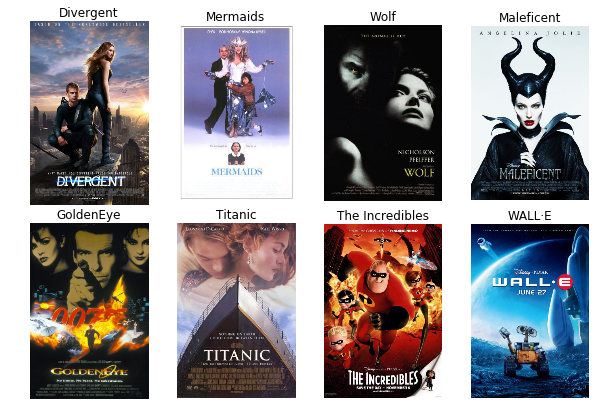

In [17]:
from skimage import io

plt.close('all')
plt.ion()

rows = 4
num_per_row = 4

fig = plt.figure(figsize=(10,14))
gs2 = gridspec.GridSpec(rows, num_per_row)
gs2.update(wspace=0.25, hspace=0.05) # set the spacing between axes. 

for i, movie in enumerate(movie_list[:8]):
    # download the image using scikit-image
    img_url = movies[movie]['Poster']
    image = io.imread(img_url)

    label = movies[movie]['Title']

    imgplot = fig.add_subplot(gs2[i]) 
    imgplot.imshow(image)
    imgplot.set_title(label, fontsize=12)
    imgplot.axis('off')

plt.show()

## Face Recognition Step:

In [18]:
#movie_list = ['divergent', 'mermaids', 'wolf', 'maleficent', 'goldeneye', 'titanic', 'incredibles', 'wall-e']

#movie_list = ['divergent', 'goldeneye', 'titanic']
movie_list = ['goldeneye', 'divergent']

movies = {}
import json, requests
baseurl = "http://omdbapi.com/?t=" #only submitting the title parameter

actors = []
for movieTitle in movie_list:
    response = requests.get(baseurl+movieTitle)
    if response.status_code == 200:
        movies[movieTitle] = json.loads(response.text)
    else:
        raise ValueError("Bad request!")
    
    for actor in movies[movieTitle]['Actors'].split(', '):
        actors.append(actor)
        print(actor)

Pierce Brosnan
Sean Bean
Izabella Scorupco
Famke Janssen
Shailene Woodley
Theo James
Ashley Judd
Jai Courtney


In [19]:
from scipy.io import loadmat

mat = loadmat('imdb_crop/imdb.mat')

In [20]:
num_entries = len( mat['imdb'][0][0][4][0] ) 

In [21]:
names = []
for i in range(num_entries):
  names.append(mat['imdb'][0][0][4][0][i][0])

In [22]:
import sets

thefile = open('actors.txt', 'w')

for aname in set(names):
  thefile.write("%s\n" % aname)

In [23]:
from skimage import io
import math

def get_image_details_by_name(actor_num, actor_name):
    gender_list = ['NaN', 'Female', 'Male']

    indexes = []  #[i for i,x in enumerate(names) if x == actor_name]
    for i, x in enumerate(names):
        #print('name: ', x)
        if x == actor_name:
            indexes.append(i)
  
    print('num lines: ', len(indexes) )
    if len(indexes) < 0:
        return
    print('num lines chk: ', len(indexes) )

  
    files = []
    for j in indexes:
        jpg_file = mat['imdb'][0][0][2][0][j][0]
        files.append([actor_num, jpg_file])
        img_url = 'imdb_crop/' + jpg_file
        im_face = io.imread(img_url)
        im_length = len(im_face.shape)
        #print('line append: ', actor_num, im_length, jpg_file)
        
        if im_length < 3:
            del(im_face)
            if files is None:
                return

        name = mat['imdb'][0][0][4][0][j][0]
        dob = jpg_file.split('_')[2]
        gender_index =  0 if (math.isnan(mat['imdb'][0][0][3][0][j]) == True) else (int(mat['imdb'][0][0][3][0][j])+1)
        gender = gender_list[gender_index]

        #print(j, jpg_file, name)
        
        label = name + ' [' + str(j) + ']' + ' - Gender: ' + gender + ';dob: ' + dob

        #cv2.imshow(label, im_face)
        #cv2.waitKey(1500)
        #cv2.destroyWindow(label)
    #print('files len: ', len(files))  
    return files

In [24]:
image_files = []
for actor_num, actor in enumerate(actors):
    print('Actor: ', actor_num, actor+'!!')
    files = get_image_details_by_name(actor_num, actor)
    #image_files.append(files)
    if files is not None:
        image_files = image_files + files
        print(len(files), len(image_files))
    else:
        print('No files....')

Actor:  0 Pierce Brosnan!!
num lines:  399
num lines chk:  399
399 399
Actor:  1 Sean Bean!!
num lines:  154
num lines chk:  154
154 553
Actor:  2 Izabella Scorupco!!
num lines:  17
num lines chk:  17
17 570
Actor:  3 Famke Janssen!!
num lines:  116
num lines chk:  116
116 686
Actor:  4 Shailene Woodley!!
num lines:  187
num lines chk:  187
187 873
Actor:  5 Theo James!!
num lines:  83
num lines chk:  83
83 956
Actor:  6 Ashley Judd!!
num lines:  193
num lines chk:  193
193 1149
Actor:  7 Jai Courtney!!
num lines:  79
num lines chk:  79
79 1228


In [25]:
image_files[-2]

[7, '74/nm2541974_rm933232128_1986-3-15_2014.jpg']

In [26]:
image_paths = image_files

In [27]:
def get_images_and_labels(image_paths):
    # Append all the absolute image paths in a list image_paths
    ##image_paths = glob.glob("./imdb_crop/[0-9]*/*.jpg")[:9]

    # to hold face images
    images = []

    # to hold the label that is assigned to the image
    labels = []
    fig = plt.figure(figsize=(2.5,3.5))
    for im_path in image_paths:
        image_path = './imdb_crop/'+im_path[1]
        # Read the image and convert to grayscale
        image_pil = Image.open(image_path).convert('L')
        # Convert the image format into numpy array
        image = np.array(image_pil, 'uint8')
        # Get the label of the image
        #nbr_str = image_path.split('/')[3].split('_')[0]
        #nbr = int(nbr_str[2:])
        nbr = im_path[0]
        
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        for (x, y, w, h) in faces:
            images.append(image[y: y + h, x: x + w])
            labels.append(nbr)
            #cv2.imshow("[" + str(nbr) + "]", image[y: y + h, x: x + w])
            #cv2.waitKey(1)

    # return the images list and labels list
    return images, labels

## Model Fitting:

In [29]:
# For face detection we will use the Haar Cascade provided by OpenCV.
cascadePath = "/Users/nlabh/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

In [30]:
# Call the get_images_and_labels function and get the face images and the 
# corresponding labels
images, labels = get_images_and_labels(image_paths)
#cv2.destroyAllWindows()

In [31]:
# For face recognition we will the the LBPH Face Recognizer 
LBPH_recognizer = cv2.face.createLBPHFaceRecognizer()
#Eigen_recognizer = cv2.face.createEigenFaceRecognizer()
Fisher_recognizer = cv2.face.createFisherFaceRecognizer()
# Perform the tranining
%time LBPH_recognizer.train(images, np.array(labels))
#%time Eigen_recognizer.train(images, np.array(labels))
#%time Fisher_recognizer.train(images, np.array(labels))

CPU times: user 4.45 s, sys: 783 ms, total: 5.23 s
Wall time: 3.53 s


In [32]:
print(np.array(labels))

[0 0 0 ..., 7 7 7]


In [33]:
recognizer = LBPH_recognizer
recognizer.getLabels()[-2]

array([7], dtype=int32)

In [34]:
# save the fitted model
recognizer.save("face_recognizer_model.save")

In [35]:
# load back the saved model
clf = cv2.face.createLBPHFaceRecognizer()
clf.load("face_recognizer_model.save")

### Predict:

./420-0.jpg
./780-1.jpg
./810-0.jpg


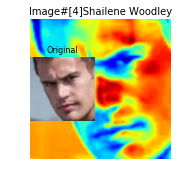

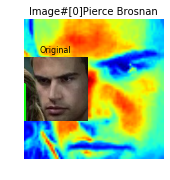

In [36]:
# pick a random subset of images
image_paths = ['./420-0.jpg', './780-1.jpg', './810-0.jpg']
#image_paths = ['./1100-1.jpg', './1100-0.jpg']
for image_path in image_paths:
    predict_image_orig = Image.open(image_path)
    predict_image_pil = Image.open(image_path).convert('L')
    predict_image = np.array(predict_image_pil, 'uint8')
    print(image_path)
    #lbl = "Face to predict..."
    #cv2.imshow(lbl, predict_image)
    #cv2.waitKey(0)
    #cv2.destroyWindow(label)
    
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        predict_image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
    fig = plt.figure(figsize=(2.5,3.5))
    for i, (x, y, w, h) in enumerate(faces):
        predict_im_face = predict_image[y: y + h, x: x + w]
        nbr_predicted = clf.predict(predict_im_face)
        
        #result = cv2.face.MinDistancePredictCollector()
        #recognizer.predict(predict_image[y: y + h, x: x + w],result, 0)
        #nbr_predicted = result.getLabel()
        #conf = result.getDist()

        label = 'Image#[' + str(nbr_predicted) + ']' + actors[nbr_predicted]
        #cv2.imshow(label, predict_image)
        #cv2.waitKey(1000)
        #cv2.destroyWindow(label)
        
        imgplot = fig.add_subplot(1,1,i+1)
        imgplot.imshow(predict_im_face)
        imgplot.set_title(label, fontsize=10)
        imgplot.axis('off')

        imgplot = fig.add_subplot(1,2,i+1)
        imgplot.imshow(predict_image_orig)
        imgplot.set_title('Original', fontsize=8)
        imgplot.axis('off')